In [1]:
import multiprocessing as mp

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [58]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional
import copy
import gc
import multiprocessing as mp

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

In [169]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')

In [255]:
def time_indexed_df(df1: pd.core.frame.DataFrame, columname: str) -> pd.core.frame.DataFrame:
    """ 
        Cast into a time-indexed dataframe.
        df1 paramater should have a column containing datetime-like data,
        which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
        or a string containing a compatible datetime (i.e. pd.to_datetime)
    """
    
    _tmp = df1.copy()
    
    pool = mp.Pool()
    _tmp[columname] = pool.map(pd.to_datetime, _tmp[columname])
    pool.close()
    pool.terminate()
    
    _tmp.index = _tmp[columname]
    _tmp.drop(columname, axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    
    return _tmp
##

def dist_plot(series: pd.core.series.Series, dropna: bool = True) -> NoReturn:
    """
    """
    
    if dropna:
        series = series.dropna()
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_box.set(xlabel='')
##


In [192]:
x = pd.read_csv('data/CareLink-Export-03-ene-2020.csv')
x["DateTime"] =  x["Date"] + " " + x["Time"]
x.drop(["Date", "Time"], axis=1, inplace=True)

/usr/local/anaconda3/envs/diab/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,8,9,10,13,14,16,17,18,34,37,39,41,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [193]:
y = time_indexed_df(x, 'DateTime')
y['hour'] = y.index.hour

In [194]:
# Deltas within minutes
for i in range(1, 11):
    y[f'd{i}'] = y['Sensor Glucose (mg/dL)'].diff(i)

In [195]:
y = y.loc['2019-12-25':, :]

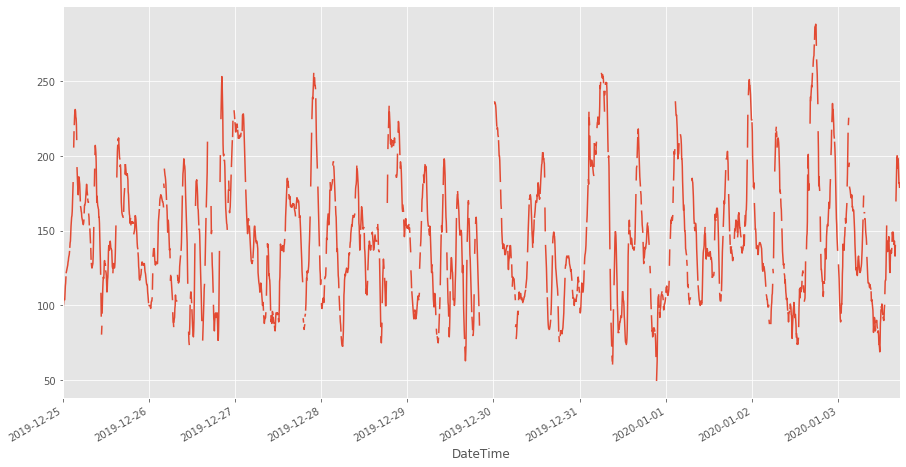

In [196]:
y['Sensor Glucose (mg/dL)'].plot()

[Text(0.5, 0, '')]

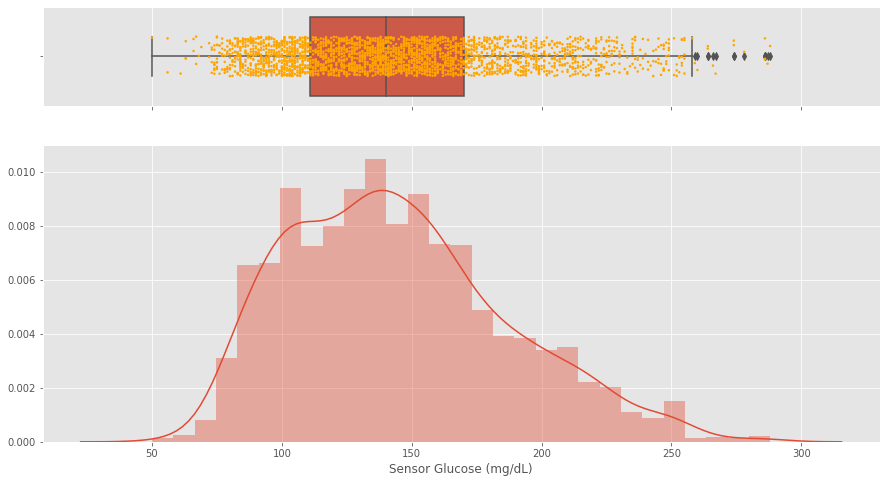

In [254]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
sns.boxplot(y['Sensor Glucose (mg/dL)'].dropna(), ax=ax_box)
sns.stripplot(y['Sensor Glucose (mg/dL)'].dropna(), color="orange", jitter=0.2, size=2.5, ax=ax_box)
sns.distplot(y['Sensor Glucose (mg/dL)'].dropna(), ax=ax_hist, kde=True)
ax_box.set(xlabel='')

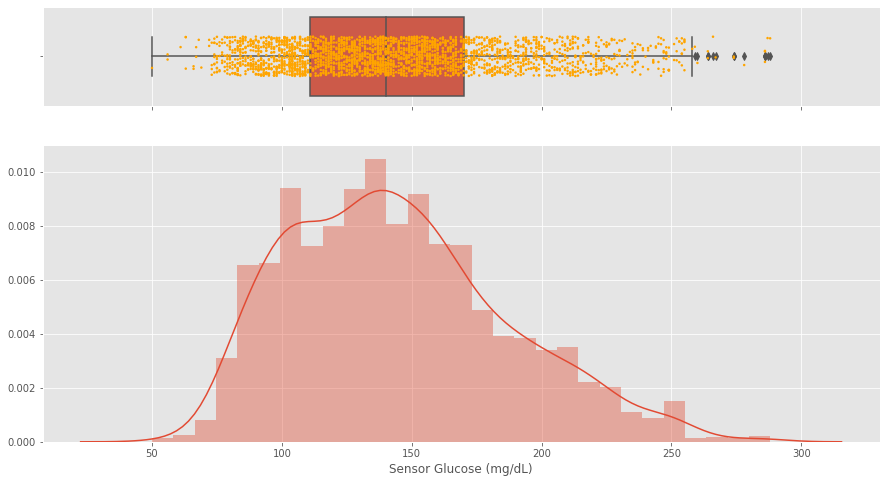

In [256]:
dist_plot(y['Sensor Glucose (mg/dL)'])

In [198]:
y.columns

Index(['Index', 'New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason', 'P

In [199]:
y.loc[ y['BWZ Carb Input (grams)'].dropna().index, 'BWZ Carb Input (grams)' ].dropna()

DateTime
2019-12-25 03:01:49     0.0
2019-12-25 07:16:10     0.0
2019-12-25 08:17:57    31.0
2019-12-25 08:42:56    61.0
2019-12-25 14:53:33    91.0
                       ... 
2020-01-03 00:47:13    24.0
2020-01-03 02:58:51     0.0
2020-01-03 07:11:21     0.0
2020-01-03 10:30:30    83.0
2020-01-03 16:28:37     0.0
Name: BWZ Carb Input (grams), Length: 71, dtype: float64

In [200]:
meal_id = y['BWZ Carb Input (grams)'].dropna().index
print(len(meal_id))

71


In [247]:
dt10 = dt.timedelta(minutes=10)
dtpost_low = dt.timedelta(hours=1, minutes=45)
dtpost_high = dt.timedelta(hours=2, minutes=45)

In [271]:
meal_descriptive = pd.core.frame.DataFrame({
    'hour': meal_id.hour, 
    'pre prandial': [ 
        y.loc[ meal - dt10 : meal + dt10,  'Sensor Glucose (mg/dL)' ].dropna().mean()
        for meal in meal_id
    ],
    'post mean': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().mean() 
        for meal in meal_id
    ], 
    'post min': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().min() 
        for meal in meal_id
    ],
    'post max': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().max() 
        for meal in meal_id
    ],
}, index=meal_id)

meal_descriptive['delta'] = meal_descriptive['post mean'] - meal_descriptive['pre prandial'] 

In [273]:
meal_descriptive.loc[  meal_descriptive.hour < 6, 'meal' ] = 'night'
meal_descriptive.loc[ (meal_descriptive.hour >= 6) & (meal_descriptive.hour < 12), 'meal'  ] = 'breakfast'
meal_descriptive.loc[ (meal_descriptive.hour >= 12) & (meal_descriptive.hour < 18), 'meal' ] = 'lunch'
meal_descriptive.loc[ (meal_descriptive.hour >= 18) & (meal_descriptive.hour < 20), 'meal' ] = 'evening'
meal_descriptive.loc[ (meal_descriptive.hour >= 20) & (meal_descriptive.hour < 24), 'meal' ] = 'dinner'

In [274]:
meal_descriptive.head()

,hour,pre prandial,post mean,post min,post max,delta,meal
DateTime,,,,,,,
2019-12-25 03:01:49,3,187.75,164.000000,155.0,181.0,-23.750000,night
2019-12-25 07:16:10,7,164.50,183.500000,165.0,207.0,19.000000,breakfast
2019-12-25 08:17:57,8,126.50,122.583333,81.0,159.0,-3.916667,breakfast
2019-12-25 08:42:56,8,159.75,106.833333,81.0,131.0,-52.916667,breakfast
2019-12-25 14:53:33,14,158.50,174.500000,159.0,194.0,16.000000,lunch


In [295]:
for i in set(meal_descriptive.meal):
    print(i, '\n', meal_descriptive[ meal_descriptive.meal == i ].describe(), '\n\n')

lunch 
             hour  pre prandial   post mean    post min   post max       delta
count  21.000000     21.000000   20.000000   20.000000   20.00000   20.000000
mean   14.761905    161.448413  142.176818  122.300000  164.60000  -17.481515
std     1.670472     44.304176   43.823126   41.251603   48.14277   63.552973
min    12.000000     91.750000   81.100000   76.000000   83.00000 -110.333333
25%    13.000000    136.250000  112.721591   84.000000  132.00000  -53.912500
50%    15.000000    148.750000  142.316667  116.000000  161.50000  -28.083333
75%    16.000000    194.500000  156.770833  145.000000  185.25000   17.333333
max    17.000000    256.000000  252.750000  237.000000  286.00000  146.500000 


dinner 
             hour  pre prandial   post mean    post min   post max       delta
count  16.000000     16.000000   16.000000   16.000000   16.00000   16.000000
mean   21.812500    177.515625  161.895833  142.687500  182.12500  -15.619792
std     1.167262     54.825288   39.668668  

In [268]:
postp = [
    y.loc[ 
        meal + dt.timedelta(hours=1, minutes=30) : meal + dt.timedelta(hours=3), 
        ['Sensor Glucose (mg/dL)', 'hour', *[f'd{i}' for i in range(1, 11)]] 
    ].dropna()
    for meal in meal_id
]

postp = pd.concat(postp)
postp.rename({'Sensor Glucose (mg/dL)': 'post points', 'b': 'Y'}, axis='columns', inplace=True)
postp.head()

,post points,hour,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10
DateTime,,,,,,,,,,,,
2019-12-25 04:51:58,176.0,4,-5.0,-7.0,-9.0,-10.0,-9.0,2.0,-1.0,-5.0,-10.0,-16.0
2019-12-25 04:56:58,170.0,4,-6.0,-11.0,-13.0,-15.0,-16.0,-15.0,-4.0,-7.0,-11.0,-16.0
2019-12-25 05:51:58,155.0,5,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-7.0,-8.0,-10.0,-11.0
2019-12-25 05:56:58,157.0,5,2.0,3.0,2.0,1.0,0.0,-1.0,-2.0,-5.0,-6.0,-8.0
2019-12-25 09:51:58,166.0,9,-1.0,-4.0,-7.0,-3.0,-15.0,-30.0,-36.0,-39.0,-41.0,-35.0


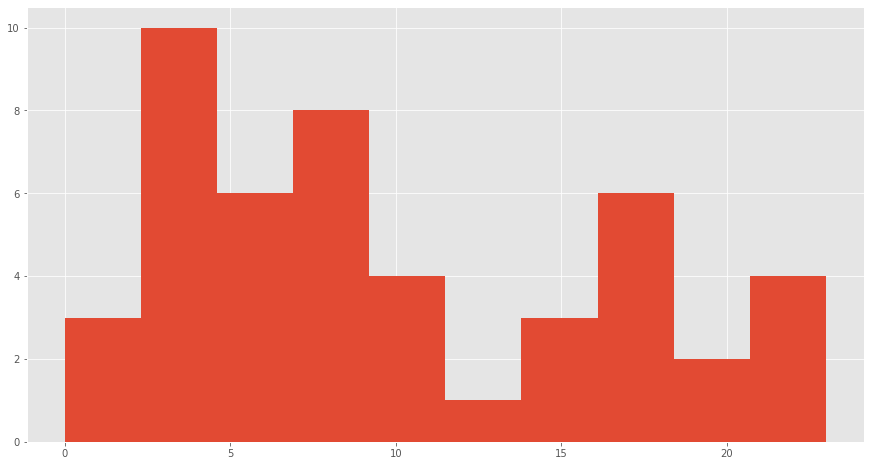

In [204]:
postp.hour.hist()

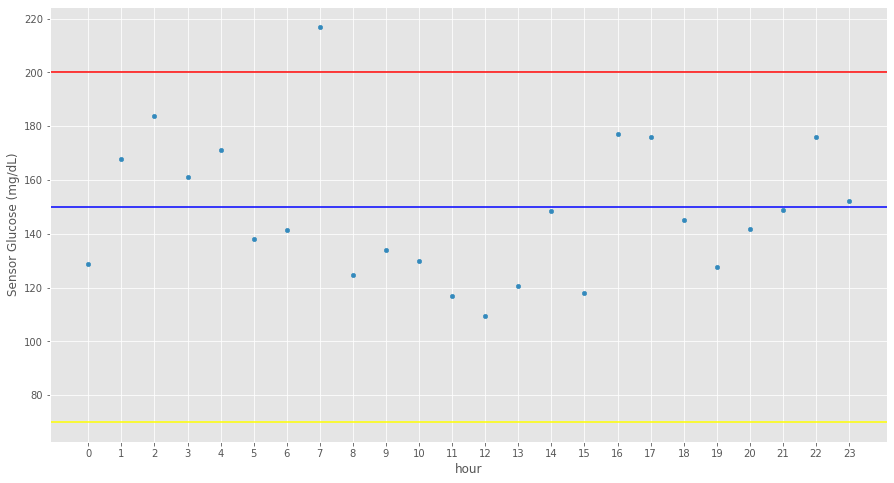

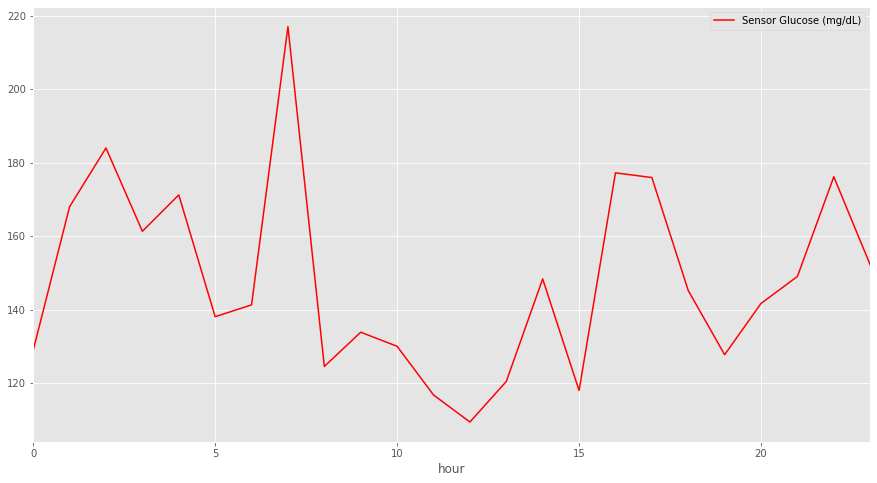

In [177]:
postp.groupby(postp.index.hour).mean().plot(
    x='hour', y='Sensor Glucose (mg/dL)', kind='scatter', grid=True, xticks=list(range(24))
)
plt.axhline(150, color='blue')
plt.axhline(200, color='red')
plt.axhline(70, color='yellow')
postp.groupby(postp.index.hour).mean().plot(x='hour', y='Sensor Glucose (mg/dL)', color='red')

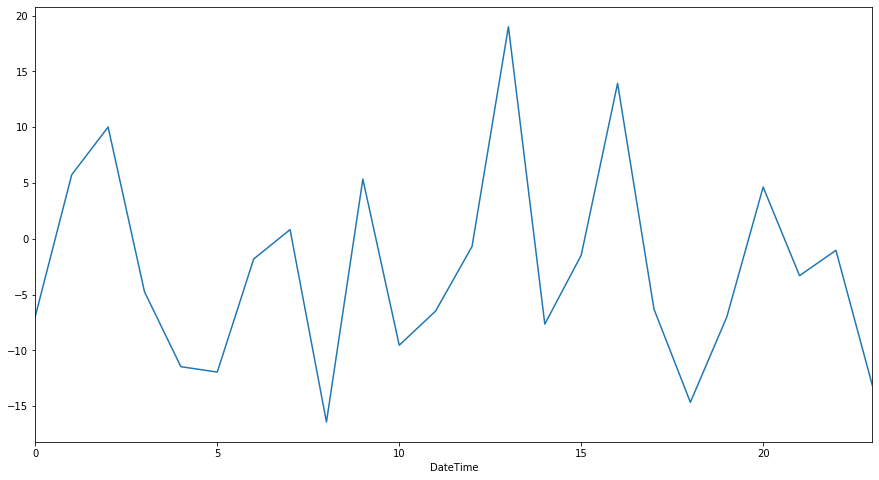

In [107]:
y['Sensor Glucose (mg/dL)'].diff(10).groupby(y.index.hour).mean().plot()

In [190]:
y.groupby('hour')['Sensor Glucose (mg/dL)'].mean()

hour
0     138.897436
1     147.233333
2     164.491667
3     169.858333
4     160.416667
5     143.483333
6     142.008333
7     146.458333
8     124.316667
9     134.258333
10    130.516667
11    112.475000
12    115.575000
13    140.091667
14    142.400000
15    142.016949
16    165.539823
17    164.283019
18    139.800000
19    134.528302
20    145.980769
21    153.375000
22    164.385417
23    156.750000
Name: Sensor Glucose (mg/dL), dtype: float64

In [112]:
hourly_mean = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).mean()
hourly_std  = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).std()

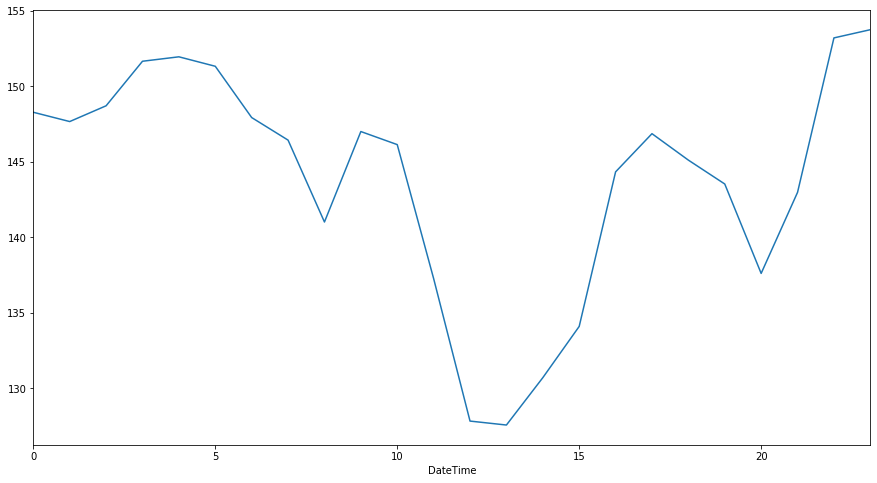

In [28]:
hourly_mean.plot()

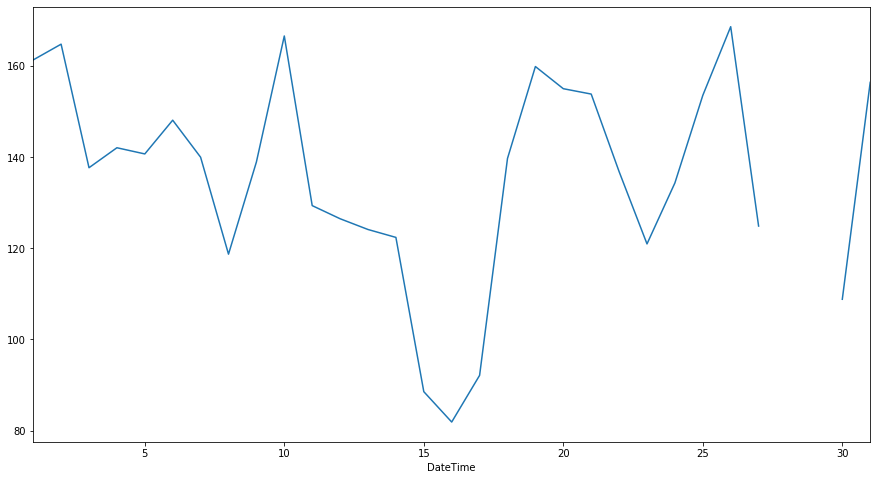

In [13]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.day).mean().plot()

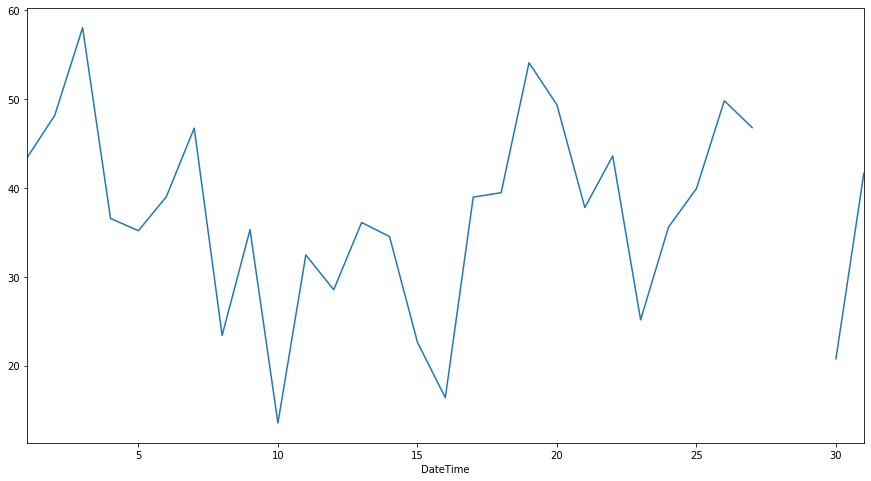

In [14]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.day).std().plot()

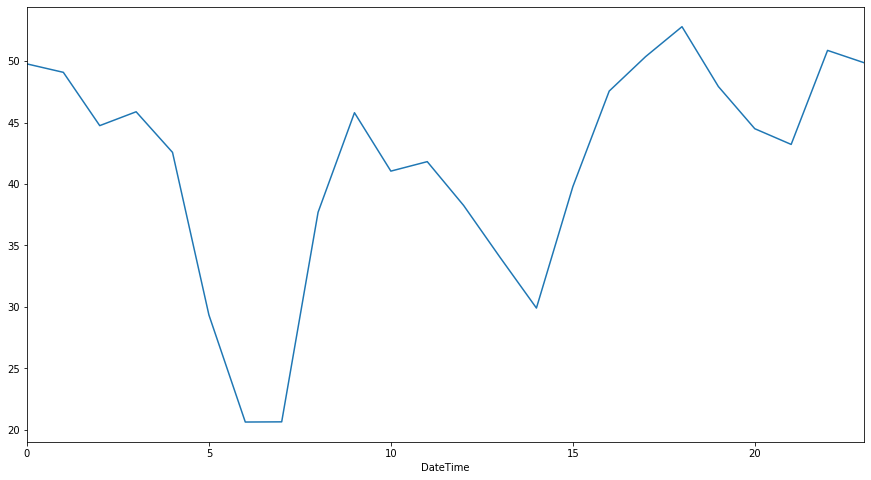

In [15]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).std().plot()

In [16]:
hourly_std.apply(lambda x: x/hourly_std.shape[0])

DateTime
0     2.073550
1     2.044991
2     1.864391
3     1.911366
4     1.773769
5     1.222983
6     0.860092
7     0.860734
8     1.570875
9     1.908137
10    1.710272
11    1.742381
12    1.593854
13    1.418132
14    1.246334
15    1.657384
16    1.981485
17    2.098222
18    2.199657
19    1.996871
20    1.853964
21    1.800740
22    2.119320
23    2.077687
Name: Sensor Glucose (mg/dL), dtype: float64

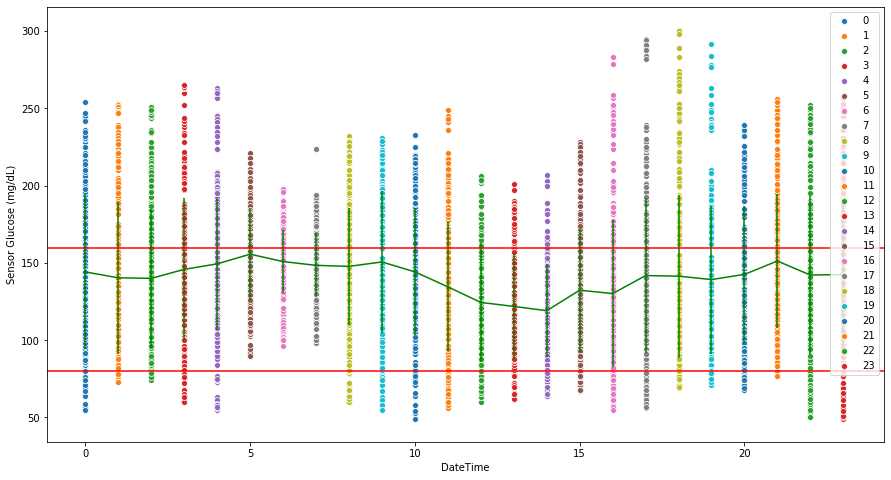

In [17]:
by_hour = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour)
for i in by_hour:
    sns.scatterplot(i[1].dropna().index.hour, i[1].dropna(), label=f"{i[0]}")
    
plt.errorbar(
    hourly_mean.index, 
    hourly_mean.to_list(), 
    yerr=hourly_std.apply(lambda x: x).to_list(),
    c='green'
)

plt.axhline(160, c='red')
plt.axhline(80, c='red')

In [18]:
z = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour)

In [19]:
for i in z:
    pass
    #sns.scatterplot(i[1].dropna().index.hour, i[1].dropna())
    #print(i[1].dropna())
    #plt.figure()
    #plt.title(f"Hour {i[0]}")
    #sns.distplot(i[1].dropna())

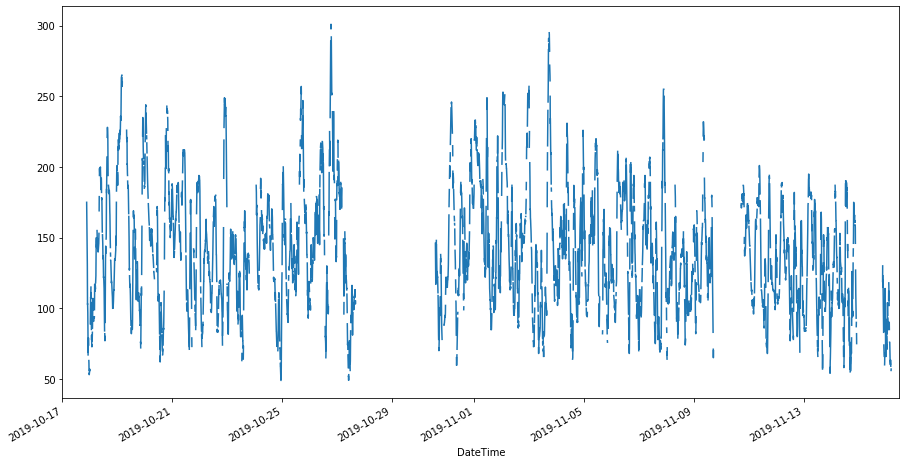

In [20]:
y['Sensor Glucose (mg/dL)'].plot()

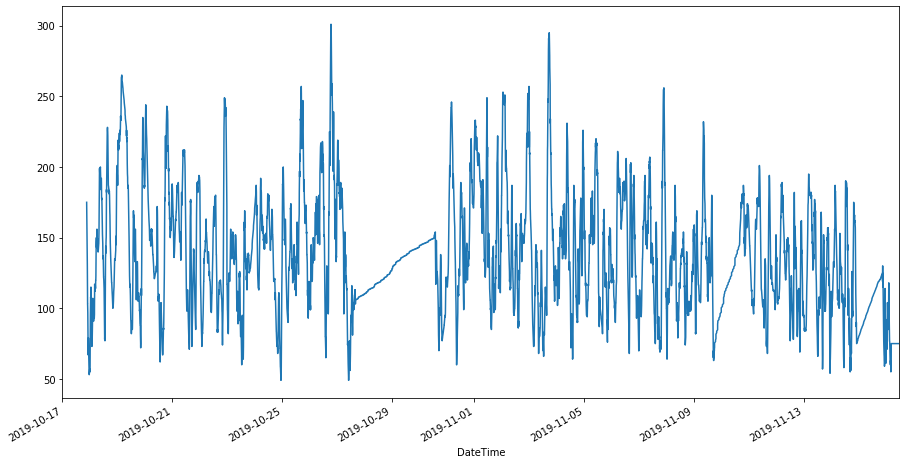

In [21]:
y['Sensor Glucose (mg/dL)'].interpolate().plot()

In [161]:
df = y['Sensor Glucose (mg/dL)']
df[np.bitwise_not(df.index.duplicated())]

DateTime
2019-10-17 00:00:00   NaN
2019-10-17 01:00:00   NaN
2019-10-17 01:11:00   NaN
2019-10-17 01:12:00   NaN
2019-10-17 02:00:00   NaN
                       ..
2019-11-16 10:50:46   NaN
2019-11-16 11:00:00   NaN
2019-11-16 11:09:43   NaN
2019-11-16 11:14:00   NaN
2019-11-16 11:46:13   NaN
Name: Sensor Glucose (mg/dL), Length: 9416, dtype: float64

In [174]:
time_series = y['Sensor Glucose (mg/dL)']
time_series =  time_series[~df.index.duplicated()].interpolate()
print(time_series.dropna().head(), '\n\n', y['Sensor Glucose (mg/dL)'].dropna())
#time_series.plot()
#decomp = seasonal_decompose(time_series)

DateTime
2019-10-17 21:15:55    169.0
2019-10-17 21:20:55    164.0
2019-10-17 21:25:55    158.0
2019-10-17 21:30:55    152.0
2019-10-17 21:35:55    143.0
Name: Sensor Glucose (mg/dL), dtype: float64 

 DateTime
2019-10-17 21:10:55    175.0
2019-10-17 21:15:55    169.0
2019-10-17 21:20:55    164.0
2019-10-17 21:25:55    158.0
2019-10-17 21:30:55    152.0
                       ...  
2019-11-16 04:17:47     55.0
2019-11-16 04:22:47     58.0
2019-11-16 04:27:47     56.0
2019-11-16 04:32:47     57.0
2019-11-16 04:37:47     75.0
Name: Sensor Glucose (mg/dL), Length: 6800, dtype: float64


In [148]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, freq=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages
    
    Parameters
    ----------
    x : array-like
        Time series. If 2d, individual series are in columns.
    model : str {"additive", "multiplicative"}
        Type of seasonal component. Abbreviations are accepted.
    filt : array-like
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by two_sided.
    freq : int, optional
        Frequency of the series. Must be used if x is not a pandas object.
        Overrides default periodicity of x if x is a pandas
        object with a timeseries index.
    two_sided : bool
        The moving average method used in filtering.
        If True (default), a centered moving average is computed using the filt.
        If F